<a href="https://www.kaggle.com/code/tousifbnn/oasis-alzheimer-s-detection-cnn?scriptVersionId=235818283" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shutil
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Transforms with grayscale conversion
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
original_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = original_dataset.classes
class_to_idx = original_dataset.class_to_idx

# Use all 4 classes (no exclusion of Non-Demented)
num_classes = len(class_names)
print("Classes:", class_names)
assert num_classes == 4, f"Expected 4 classes, got {num_classes}"

# Balance the dataset (488 images per class)
indices_per_class = {i: [] for i in range(num_classes)}
for idx, label in enumerate(original_dataset.targets):
    indices_per_class[label].append(idx)

# Take 488 samples per class
balanced_indices = []
balanced_labels = []
for label in range(num_classes):
    selected_indices = indices_per_class[label][:488]  # Limit to 488 per class
    balanced_indices.extend(selected_indices)
    balanced_labels.extend([label] * len(selected_indices))

print("Balanced dataset size:", len(balanced_indices))

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Balanced dataset size: 1952


In [2]:
# Split balanced dataset
train_idx, val_idx = train_test_split(
    list(range(len(balanced_indices))),
    test_size=0.2, stratify=balanced_labels, random_state=42
)

train_indices = [balanced_indices[i] for i in train_idx]
val_indices = [balanced_indices[i] for i in val_idx]

train_dataset = torch.utils.data.Subset(original_dataset, train_indices)
val_dataset = torch.utils.data.Subset(original_dataset, val_indices)

# Data loaders
batch_size = 64
num_workers = 4
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

# MLP Model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=64*64, hidden_size1=512, hidden_size2=256, num_classes=4):  # 4 classes
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize model, loss, optimizer
model = SimpleMLP(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # No class weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 6
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validate every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    else:
        val_losses.append(val_losses[-1] if val_losses else 0)
        val_accuracies.append(val_accuracies[-1] if val_accuracies else 0)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    if (epoch + 1) % 2 == 0:
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch [1/6]
Train Loss: 1.4912, Train Accuracy: 31.26%
Epoch [2/6]
Train Loss: 1.1214, Train Accuracy: 52.66%
Val Loss: 0.7526, Val Accuracy: 78.26%
Epoch [3/6]
Train Loss: 0.7074, Train Accuracy: 73.86%
Epoch [4/6]
Train Loss: 0.3646, Train Accuracy: 87.38%
Val Loss: 0.0968, Val Accuracy: 98.98%
Epoch [5/6]
Train Loss: 0.2201, Train Accuracy: 93.72%
Epoch [6/6]
Train Loss: 0.1342, Train Accuracy: 96.28%
Val Loss: 0.0314, Val Accuracy: 99.74%


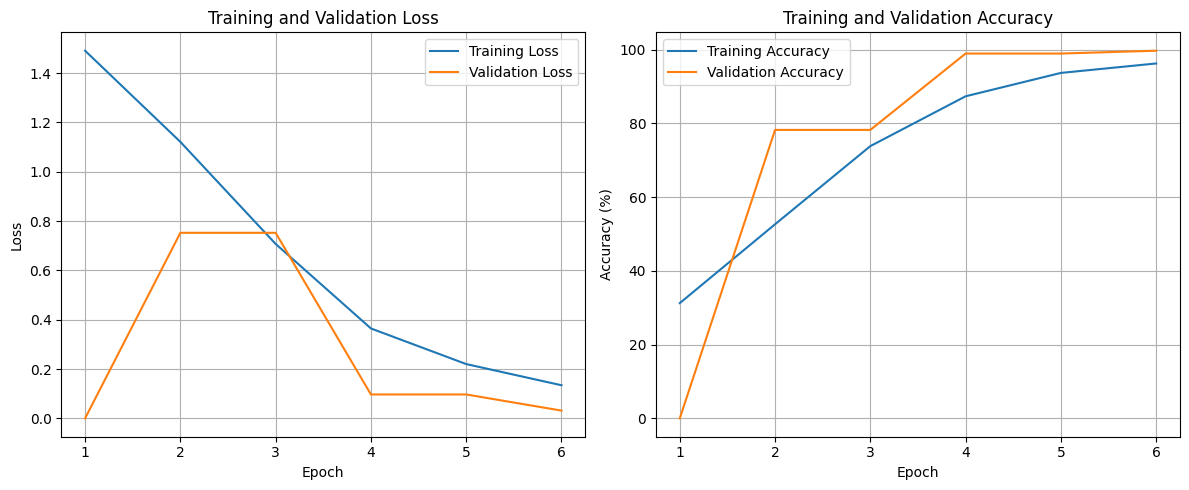

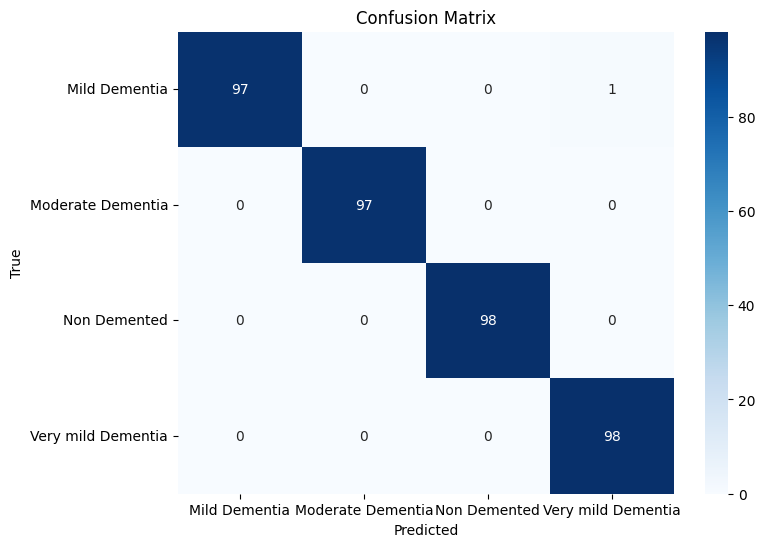


Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      0.99      0.99        98
 Moderate Dementia       1.00      1.00      1.00        97
      Non Demented       1.00      1.00      1.00        98
Very mild Dementia       0.99      1.00      0.99        98

          accuracy                           1.00       391
         macro avg       1.00      1.00      1.00       391
      weighted avg       1.00      1.00      1.00       391



In [3]:
# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_mlp_4classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix and class-wise metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_mlp_4classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Save model
torch.save(model.state_dict(), 'mlp_alzheimer_4classes.pth')